In [1]:
# Original Source: https://www.kaggle.com/teamaker/clustering-teams-based-on-style-of-play
# Dataset https://www.kaggle.com/teamaker/clustering-teams-based-on-style-of-play/data
import pandas as pd
import numpy as np
import sqlite3

In [2]:
con = sqlite3.connect("./database.sqlite")
team=pd.read_sql_query('select * from Team', con)
team_attr=pd.read_sql_query('select * from Team_Attributes', con)
con.close()

df = pd.merge(team, team_attr, how='inner', left_on='team_api_id', right_on='team_api_id')
print (df.shape)

(1458, 29)


In [3]:
df.sample(n=10)

,id_x,team_api_id,team_fifa_api_id_x,team_long_name,team_short_name,id_y,team_fifa_api_id_y,date,buildUpPlaySpeed,buildUpPlaySpeedClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1073,35290,10264,1896.0,SC Braga,BRA,233,1896,2012-02-22 00:00:00,53,Balanced,...,52,Normal,Organised,23,Deep,48,Press,39,Normal,Cover
1212,43035,10267,461.0,Valencia CF,VAL,1311,461,2013-09-20 00:00:00,20,Slow,...,55,Normal,Organised,51,Medium,38,Press,59,Normal,Cover
1051,35285,9768,237.0,Sporting CP,SCP,1197,237,2014-09-19 00:00:00,55,Balanced,...,55,Normal,Organised,60,Medium,60,Press,54,Normal,Cover
496,15617,9823,21.0,FC Bayern Munich,BMU,147,21,2014-09-19 00:00:00,37,Balanced,...,40,Normal,Free Form,61,Medium,59,Press,40,Normal,Cover
576,15631,9788,23.0,Borussia Mönchengladbach,GLA,220,23,2014-09-19 00:00:00,31,Slow,...,49,Normal,Free Form,43,Medium,50,Press,41,Normal,Cover
1176,39395,9925,78.0,Celtic,CEL,291,78,2012-02-22 00:00:00,70,Fast,...,60,Normal,Organised,50,Medium,50,Press,60,Normal,Cover
202,3474,9879,144.0,Fulham,FUL,482,144,2013-09-20 00:00:00,52,Balanced,...,59,Normal,Organised,39,Medium,39,Press,57,Normal,Cover
472,12595,10242,294.0,ES Troyes AC,TRO,1291,294,2014-09-19 00:00:00,49,Balanced,...,46,Normal,Organised,43,Medium,42,Press,52,Normal,Cover
1302,43050,10281,462.0,Real Valladolid,VAL,1324,462,2014-09-19 00:00:00,55,Balanced,...,41,Normal,Organised,51,Medium,50,Press,60,Normal,Cover
1113,35774,2033,111540.0,S.C. Olhanense,OLH,928,111540,2010-02-22 00:00:00,45,Balanced,...,45,Normal,Free Form,50,Medium,45,Press,60,Normal,Cover


In [4]:
cols_to_keep = ['date', 'team_long_name', u'buildUpPlaySpeed', u'buildUpPlayDribbling',
         u'buildUpPlayPassing', u'chanceCreationPassing', u'chanceCreationCrossing',
       u'chanceCreationShooting', u'defencePressure', u'defenceAggression', u'defenceTeamWidth']
df = df[cols_to_keep]

In [5]:
old_df = df.copy(deep=True)

In [6]:
aggs = df.groupby('team_long_name')['date'].max().to_frame()
df.drop('date', axis=1, inplace=True)
df.drop_duplicates(subset='team_long_name', keep='last', inplace=True)
df = df.merge(right=aggs, right_index=True, left_on='team_long_name', how='right')
df = df.dropna()
df.set_index('team_long_name', inplace=True)
df.drop('date', axis=1, inplace=True)
print (df.shape)

(260, 9)


In [7]:
index = old_df.team_long_name[old_df.team_long_name.str.contains(pat = 'Manches')].index
for i in index:
    print(old_df.iloc[[i]])


                   date     team_long_name  buildUpPlaySpeed  \
97  2010-02-22 00:00:00  Manchester United                70   

    buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
97                   NaN                  45                     45   

    chanceCreationCrossing  chanceCreationShooting  defencePressure  \
97                      70                      65               40   

    defenceAggression  defenceTeamWidth  
97                 50                40  
                   date     team_long_name  buildUpPlaySpeed  \
98  2011-02-22 00:00:00  Manchester United                65   

    buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
98                   NaN                  40                     65   

    chanceCreationCrossing  chanceCreationShooting  defencePressure  \
98                      65                      70               45   

    defenceAggression  defenceTeamWidth  
98                 45                65  
  

## PCA

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = df.copy()
x_normalized = StandardScaler().fit(x).transform(x)  

pca = PCA(n_components = 3).fit(x_normalized)
print (pca.explained_variance_ratio_)

[0.19677852 0.1868464  0.12810027]


In [9]:
np.sum([pca.explained_variance_ratio_])

0.5117251758763541

We can improve this!

## Multi Dimensional Scaling (MDS).

In [10]:
from sklearn.manifold import MDS

mds = MDS(n_components = 2, n_init = 10)
mds_2 = MDS(n_components = 3, n_init = 10)
x_mds = mds.fit_transform(x_normalized)
x_mds_2 = mds_2.fit_transform(x_normalized)

In [11]:
team_names = ['Liverpool', 'ES Troyes AC', 'Real Madrid CF', 'Arsenal', 'Swansea City', 'Manchester United']
team_maps = {}
for team in team_names:
    print (team, df.index.get_loc(team))
    team_maps[team] = df.index.get_loc(team)

Liverpool 23
ES Troyes AC 79
Real Madrid CF 222
Arsenal 20
Swansea City 42
Manchester United 18


In [12]:
def diff(a,b):
    sum = 0
    for i in range(len(a)):
        sum += (a[i]-b[i])*(a[i]-b[i])
    return sum

In [13]:
print ("Before MDS: ")
i=-1
for team in team_names:
    i+=1
    for j in range(i+1,4):
        print ("{} and {} diff : {}".format(team, team_names[j],
                                            diff(df.iloc[team_maps[team]].tolist(), 
                                            df.iloc[team_maps[team_names[j]]].tolist())))

Before MDS: 
Liverpool and ES Troyes AC diff : 1263.0
Liverpool and Real Madrid CF diff : 1402.0
Liverpool and Arsenal diff : 636.0
ES Troyes AC and Real Madrid CF diff : 1067.0
ES Troyes AC and Arsenal diff : 1219.0
Real Madrid CF and Arsenal diff : 2138.0


In [14]:
print ("After MDS (keeping 3 components) : ")
i=-1
for team in team_names:
    i+=1
    for j in range(i+1,4):
        print ("{} and {} diff : {}".format(team, team_names[j], 
                                           diff(x_mds_2[team_maps[team]], x_mds_2[team_maps[team_names[j]]])))

After MDS (keeping 3 components) : 
Liverpool and ES Troyes AC diff : 13.68006081989818
Liverpool and Real Madrid CF diff : 12.116927780573683
Liverpool and Arsenal diff : 3.369952164783861
ES Troyes AC and Real Madrid CF diff : 15.059073559574559
ES Troyes AC and Arsenal diff : 10.61256949086824
Real Madrid CF and Arsenal diff : 20.453749900236172


In [15]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (30,30)

def plot_labelled_scatter_3D(X, y, class_labels, team_maps):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[:, 0], X[:, 1], X[:,2], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)
    for i, x, y, z in zip(range(len(X[:,0])), X[:, 0], X[:, 1], X[:, 2]):       
        if i in team_maps.values():
            for team in team_maps.items():
                if team[1] == i:
                    team_name = team[0]
                
            ax.text(x, y, z, team_name)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

In [16]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (30,30)

def plot_labelled_scatter_3D(X, y, class_labels, team_maps):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[:, 0], X[:, 1], X[:,2], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)
    for i, x, y, z in zip(range(len(X[:,0])), X[:, 0], X[:, 1], X[:, 2]):       
        if i in team_maps.values():
            for team in team_maps.items():
                if team[1] == i:
                    team_name = team[0]
                
            ax.text(x, y, z, team_name)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

def plot_labelled_scatter(X, y, class_labels, team_maps):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)
    for i, x, y in zip(range(len(X[:,0])), X[:, 0], X[:, 1]):       
        if i in team_maps.values():
            for team in team_maps.items():
                if team[1] == i:
                    team_name = team[0]
                
            plt.annotate(
                team_name,
                xy=(x, y), xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

# Kmeans

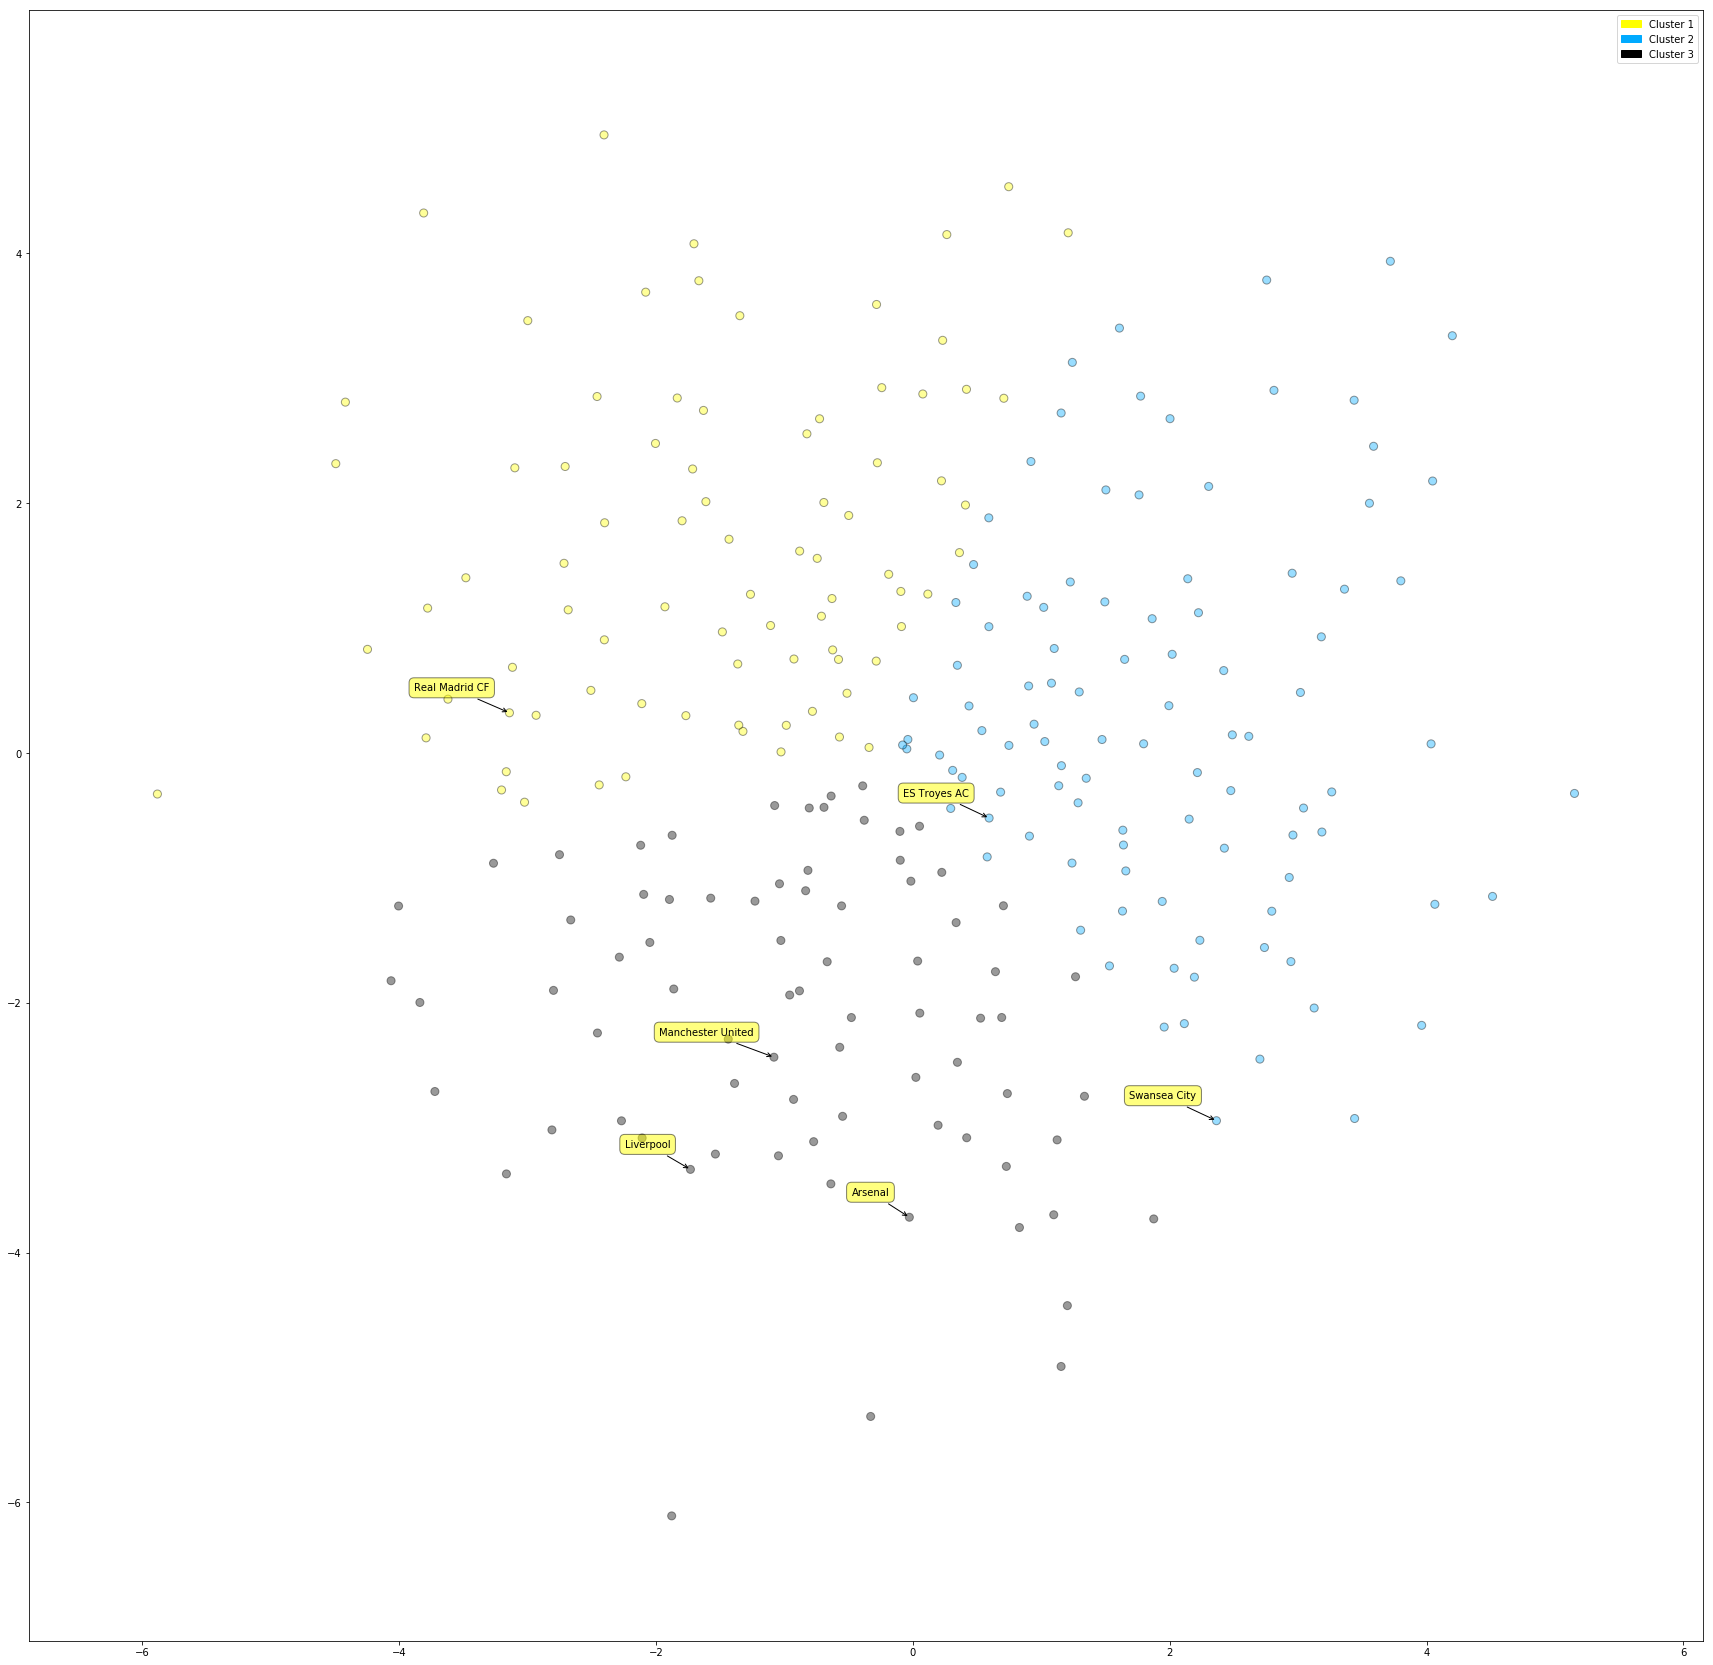

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters = 3, random_state=10)
kmeans.fit(x_mds)
plot_labelled_scatter(x_mds, kmeans.labels_, ['Cluster 1', 'Cluster 2', 'Cluster 3'], team_maps)

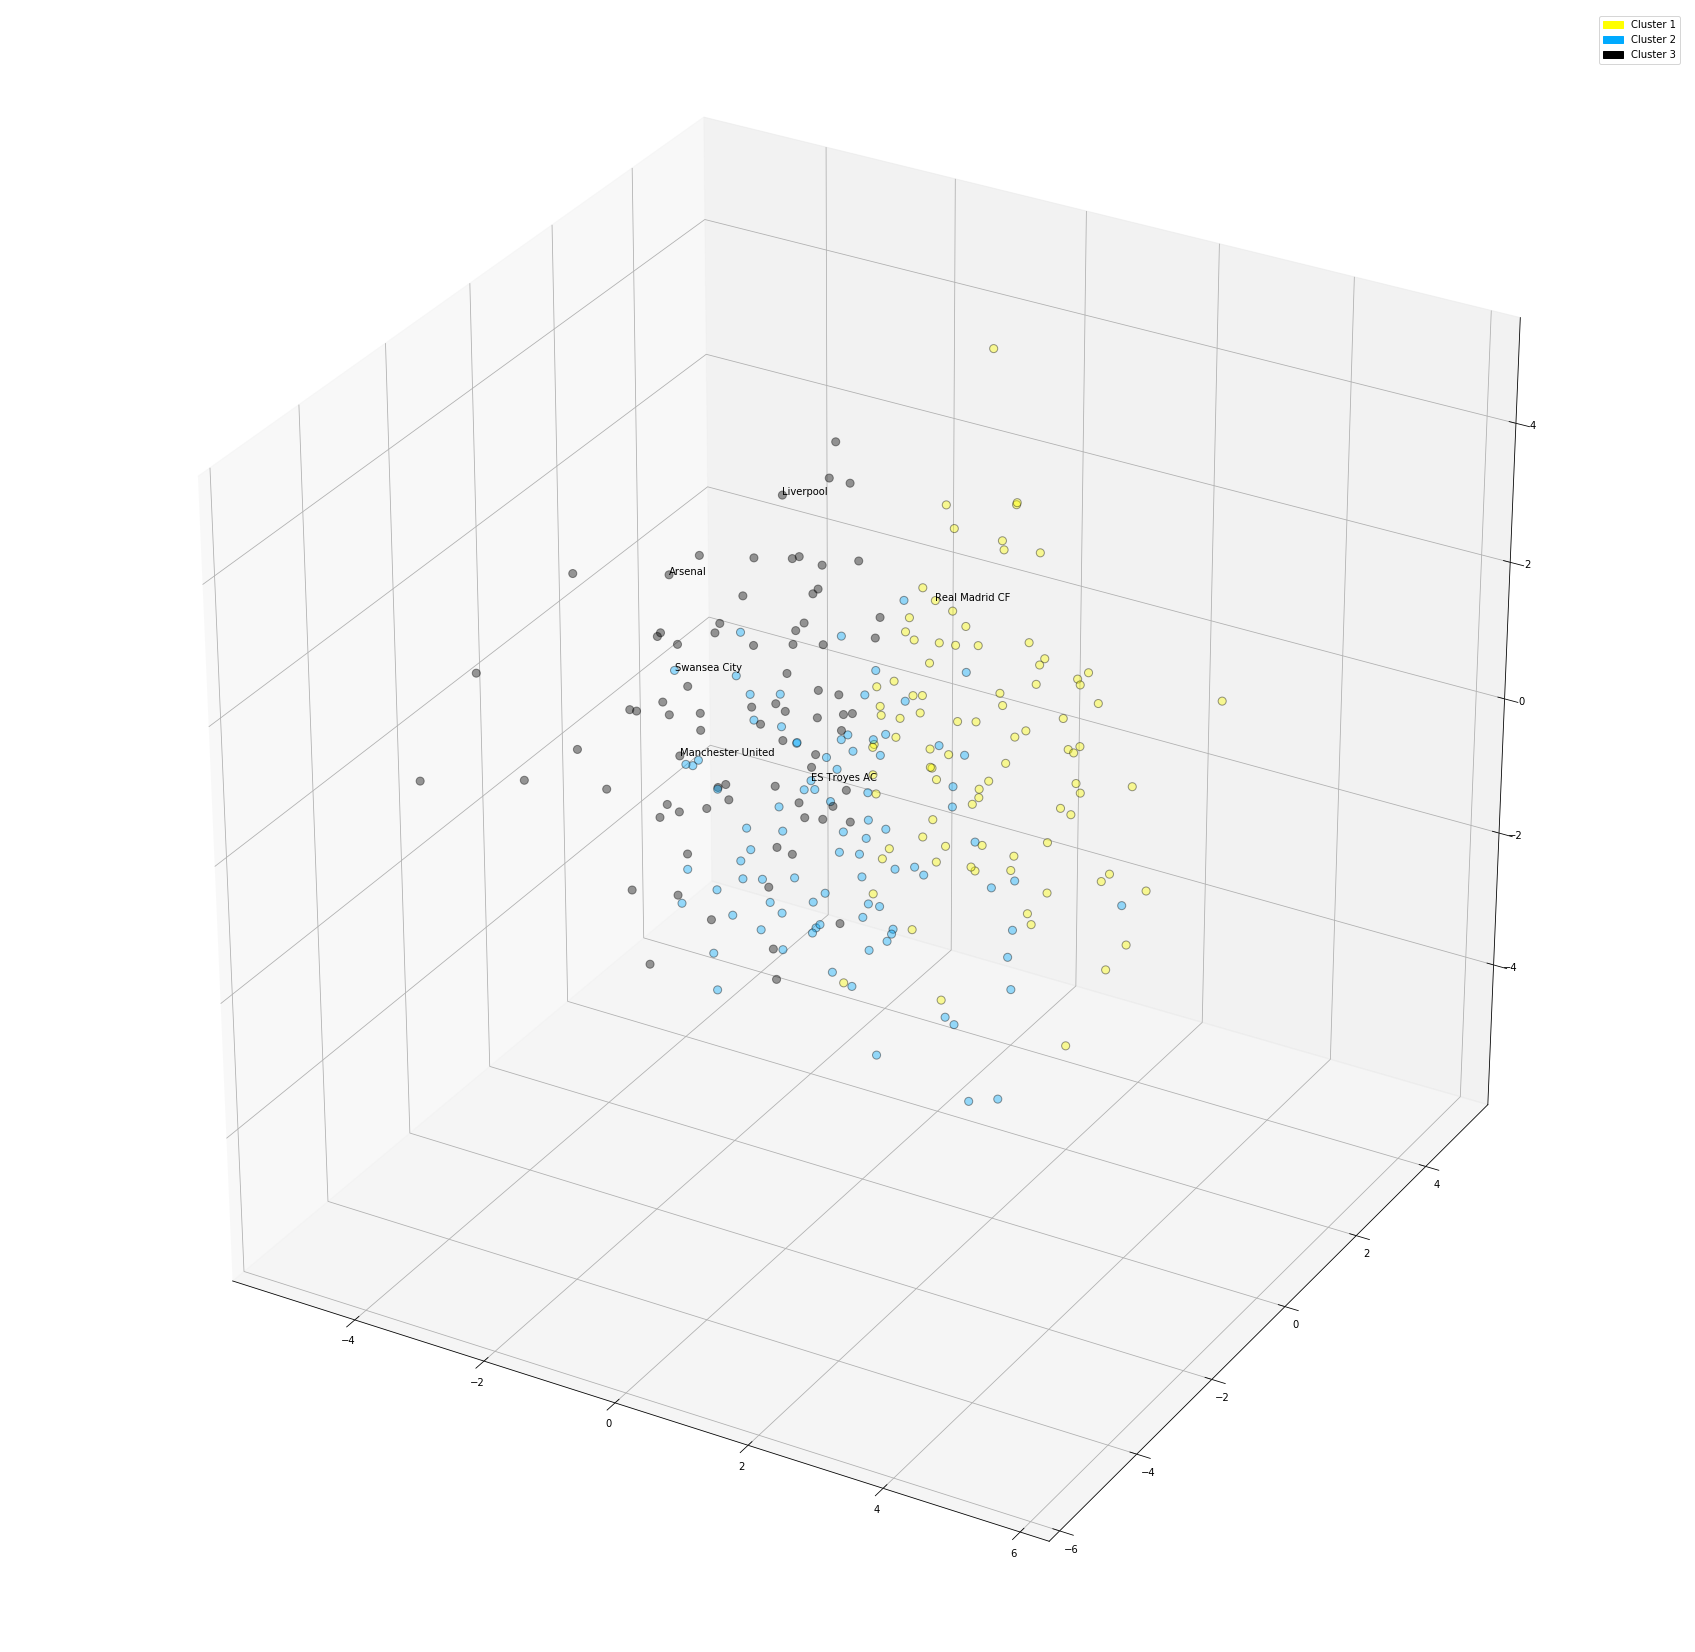

In [24]:
kmeans = KMeans(n_clusters = 3, random_state=10)
kmeans.fit(x_mds_2)
plot_labelled_scatter_3D(x_mds_2, kmeans.labels_, ['Cluster 1', 'Cluster 2', 'Cluster 3'], team_maps)

In [18]:
old_df.iloc[[246, 114, 1244, 132, 394]]

,date,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
246,2015-09-10 00:00:00,Swansea City,45,44.0,42,34,36,55,31,47,42
114,2015-09-10 00:00:00,Arsenal,59,51.0,30,28,44,46,51,44,52
1244,2015-09-10 00:00:00,Real Madrid CF,50,57.0,46,61,41,63,52,60,63
132,2015-09-10 00:00:00,Liverpool,66,60.0,45,34,34,46,51,52,61
394,2015-09-10 00:00:00,Olympique de Marseille,51,77.0,41,49,69,31,48,48,60


# Spectral Clustering

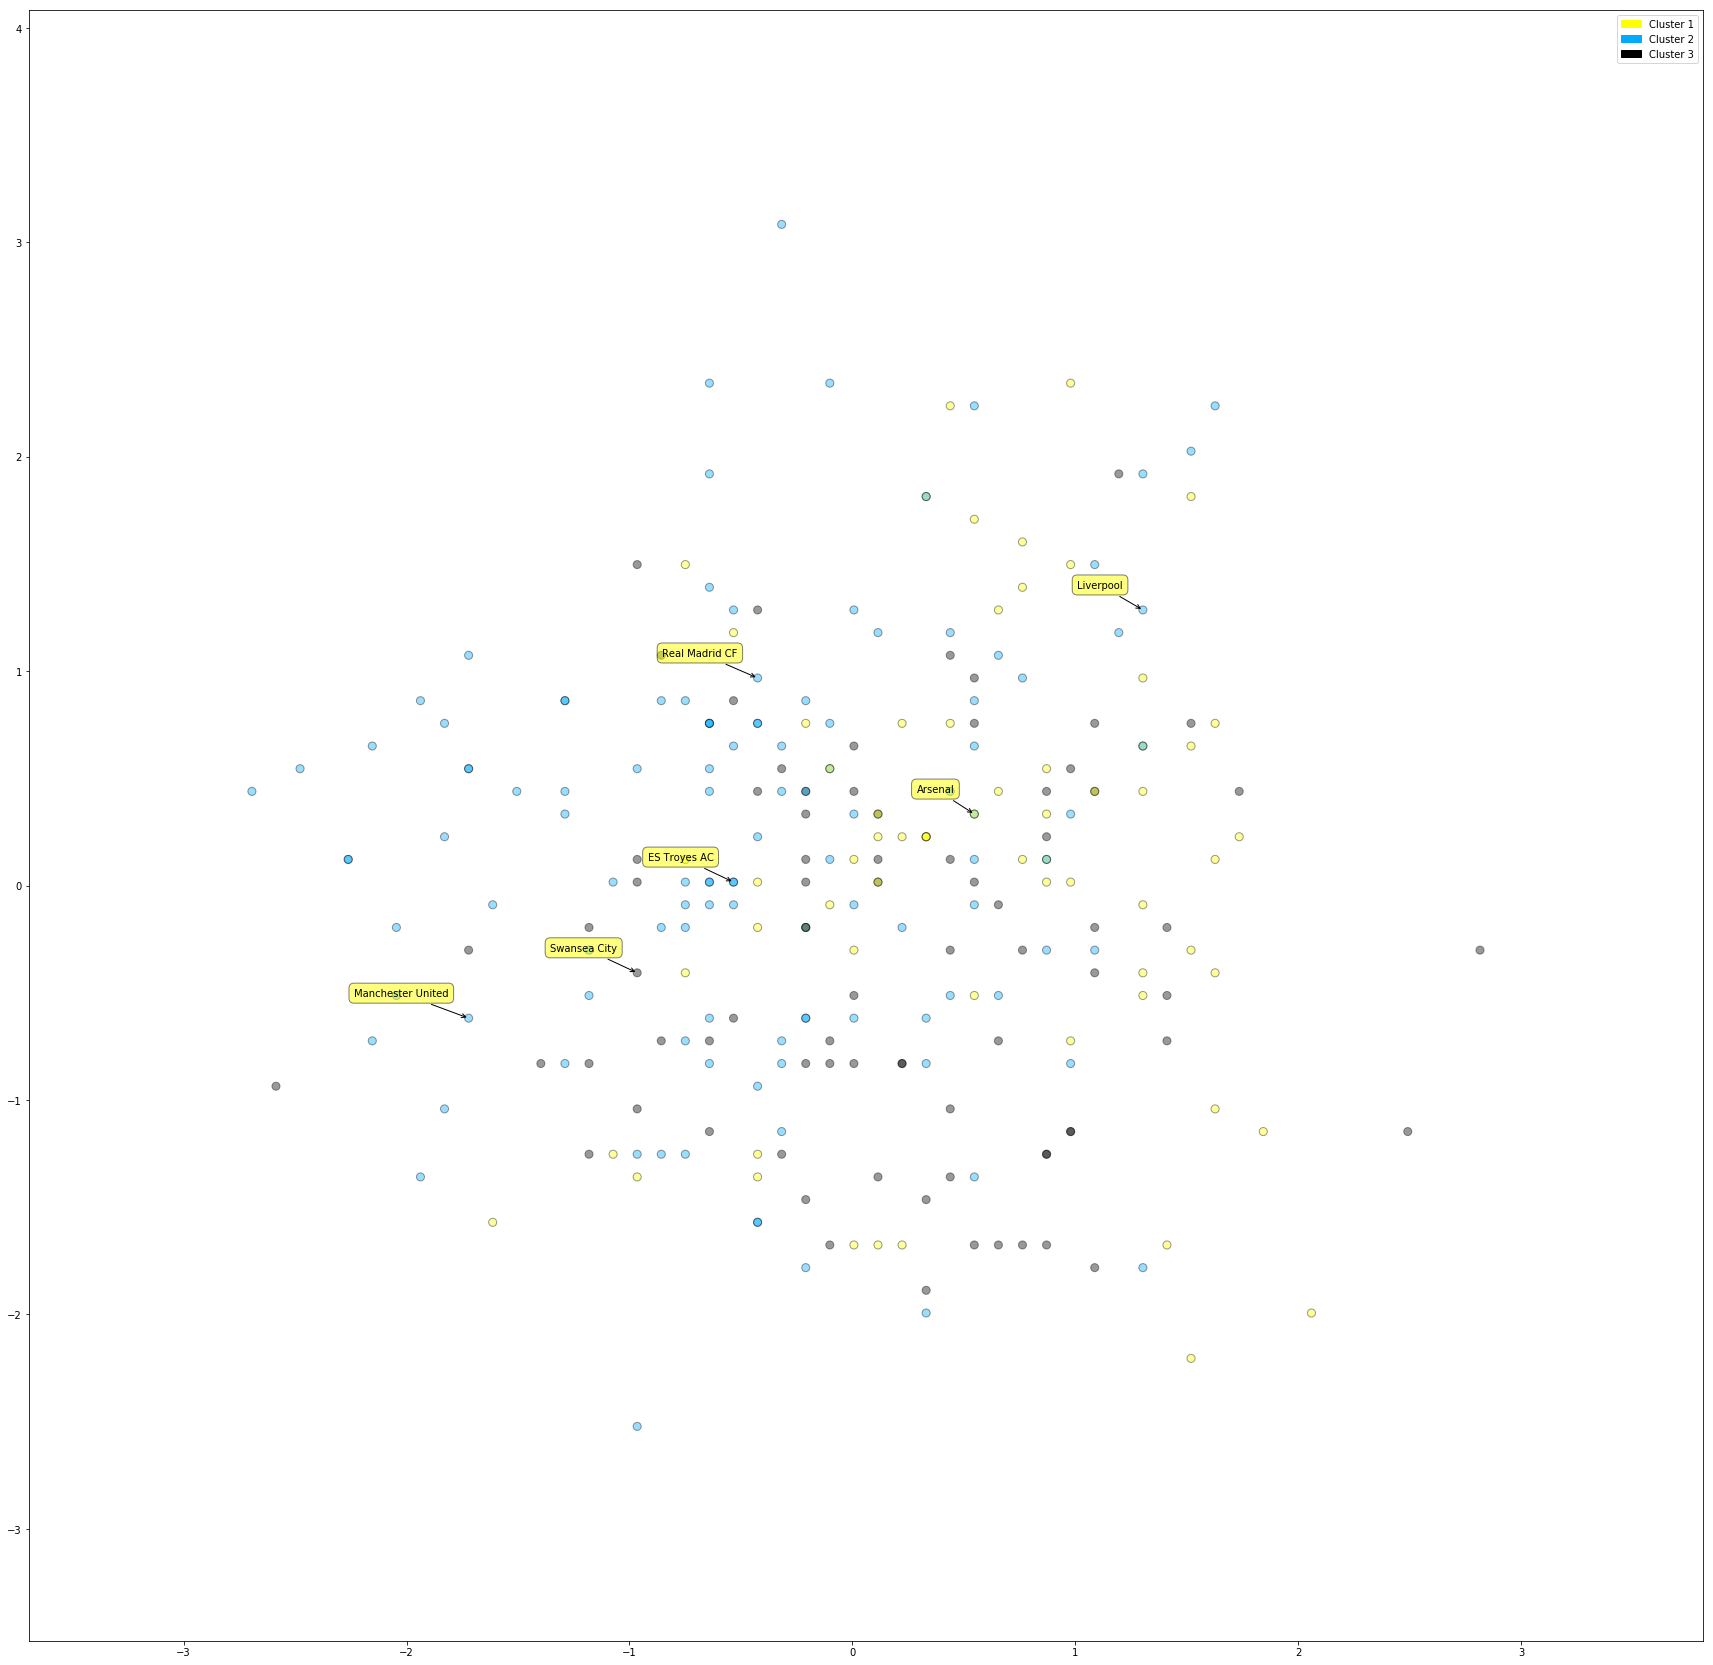

In [51]:
from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=3, affinity='nearest_neighbors')
spectral.fit(x_normalized)
plot_labelled_scatter(x_normalized, spectral.labels_, ['Cluster 1', 'Cluster 2', 'Cluster 3'], team_maps)

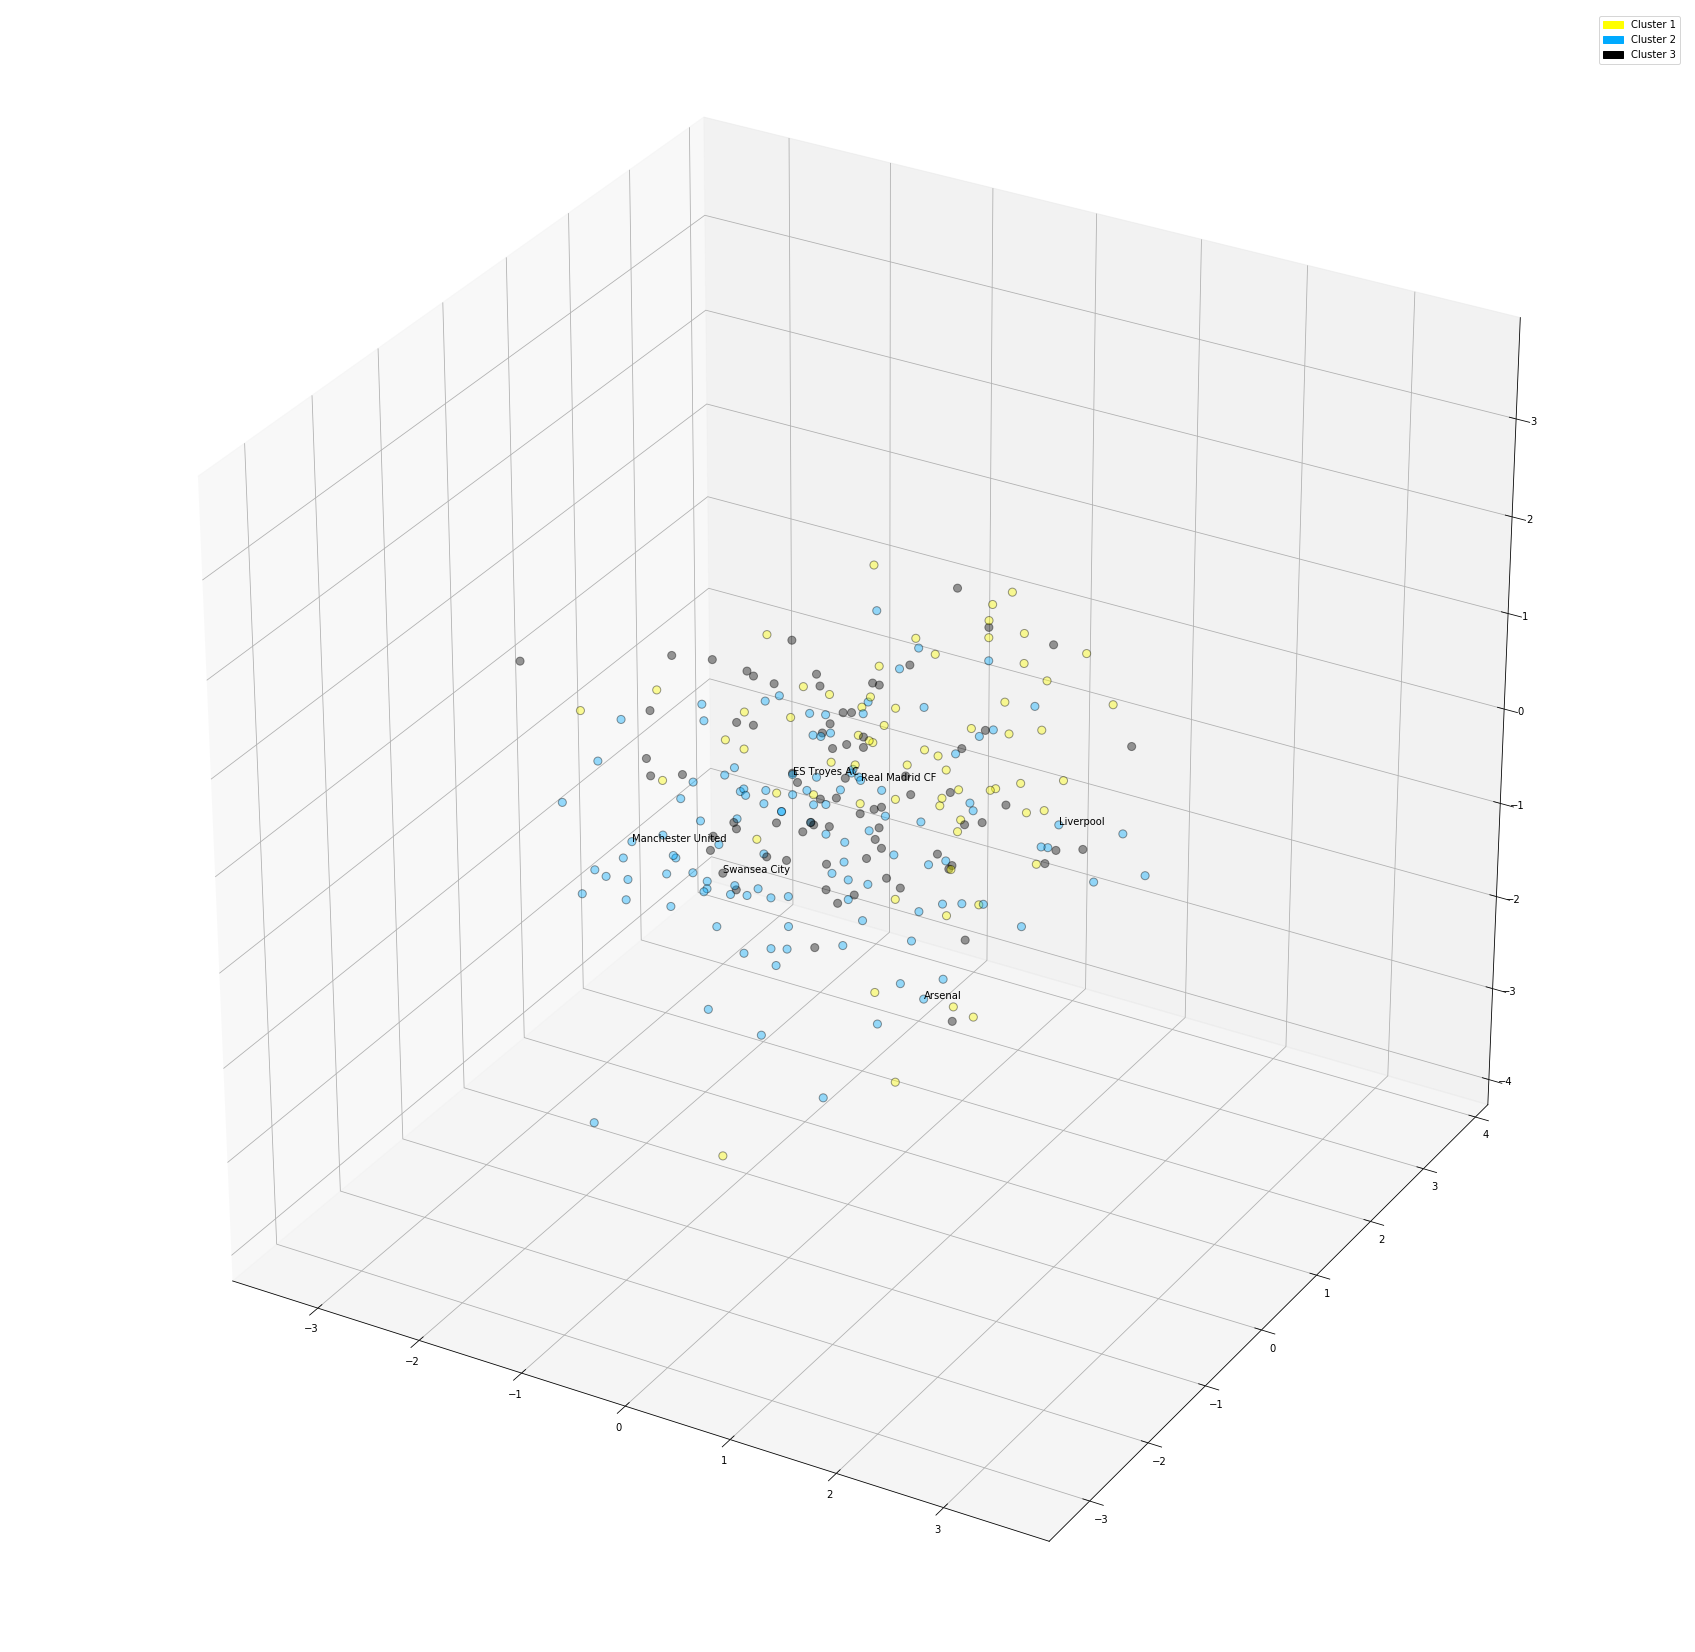

In [50]:
plot_labelled_scatter_3D(x_normalized, spectral.labels_, ['Cluster 1', 'Cluster 2', 'Cluster 3'], team_maps)